# pyLPM: Python lumped parameter model notebook

This notebook is desinged to replicate some of the functions in TracerLPM (https://ca.water.usgs.gov/user_projects/TracerLPM/).

The models take the form of the convolution integral:  
$$
C_{out}(t) = \int_{-\infty}^{t} C_{in}(t')e^{-\lambda(t-t')}g(t-t')dt'
$$
where  
$C_{out}t$ is the outlet tracer concentration at time $t$  
$C_{in}(t')$ is the input concentration at time $t'$  
$t$ is the sample date  
$t'$ is the date when the input concentration entered the system  
$\lambda$ is the decay constant per unit time  
$t-t'$ the age of the water parcel  
$g(t-t')$ the exit age distribution function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Examples of age distribution functions

### Piston-flow model

$$
PFM_{g(t-t')} = \delta(t-t'-\tau_s)
$$
where $\delta$ is Dirac delta function and $\tau_s$ is the mean residence time.

In [2]:
def pfm(t, tau):
    return [1 if x == tau else 0 for x in t]

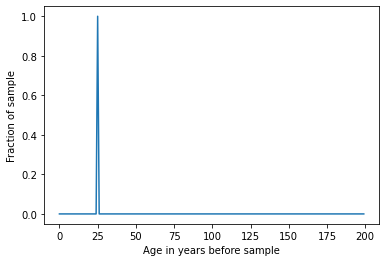

In [3]:
tt = np.arange(0, 200)
tau = 25
gt = pfm(tt, tau)
plt.plot(gt)
plt.xlabel('Age in years before sample')
plt.ylabel('Fraction of sample')
plt.show()

### Exponential mixing model
$$
EMM_{g(t-t')} = \frac{1}{\tau_s}e^{ (-\frac{t-t'}{\tau_s}) }
$$

In [4]:
def emm(tt, tau):
    return 1/tau * np.exp(-(tt)/tau)

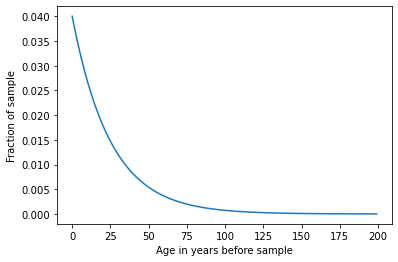

In [5]:
tt = np.arange(0, 200)
tau = 25
gt = emm(tt, tau)
plt.plot(gt)
plt.xlabel('Age in years before sample')
plt.ylabel('Fraction of sample')
plt.show()

### Exponential piston flow model

$$
EPM_{g(t-t')} = \frac{n}{\tau_s}e^{(-\frac{n(t-t')}{\tau_s}+n-1)} \text{, for } t>\tau_s(1-\frac{1}{n});0
$$


In [6]:
def epm(tt, tau, n):
    x = n/tau * np.exp(-(n*tt/tau) + n - 1)
    x[tt<tau*(1-1/n)] = 0
    return x

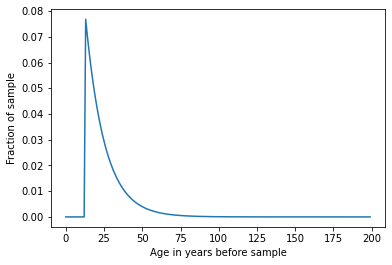

In [7]:
n = 2
gt = epm(tt, tau, n)
plt.plot(gt)
plt.xlabel('Age in years before sample')
plt.ylabel('Fraction of sample')
plt.show()

# Example using Missouri River data

The data is available from within TracerLPM (see example 3 in the TracerLPM manual).

In [8]:
df = pd.read_csv('Missouri.csv')

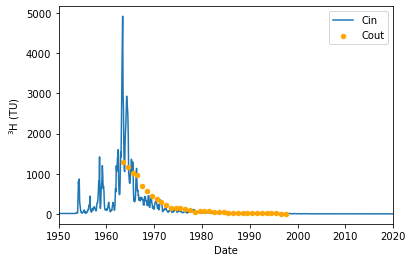

In [9]:
fig, ax = plt.subplots()
df.plot(x='Date', y='Cin', ax=ax, zorder=0)
df.plot.scatter(x='Date', y='Cout', ax=ax, label='Cout', c='orange', zorder=1)
plt.ylabel('$^3$H (TU)')
plt.xlim(1950, 2020)
plt.show()

In [10]:
dates = df['Date'].values
Cin = df['Cin'].values
Cout_obs_dates = df.dropna()['Date'].values
Cout_obs = df.dropna()['Cout'].values

sample_dates = dates[dates>=1940]
lambd = np.log(2)/12.32
uz_time = 0

### PFM

Define the piston flow model functions.

In [11]:
def lpm_pfm(sample_dates, dates, Cin, lambd, tau, uz_time):
    Cout = []
    for sample_date in sample_dates:
        idx = np.argmax(dates <= sample_date-tau)
        Cout.append( Cin[idx] * np.exp(-lambd*tau) )
    return Cout

In [12]:
tau = 1.5
Cout_sim = lpm_pfm(sample_dates, dates, Cin, lambd, tau, uz_time)

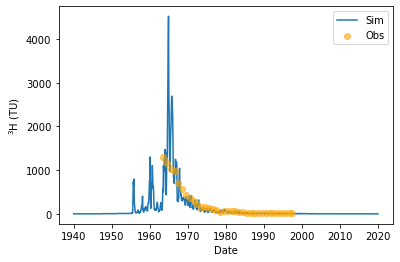

In [13]:
plt.plot(sample_dates, Cout_sim, zorder=0)
plt.scatter(Cout_obs_dates, Cout_obs, c='orange', alpha=0.6, zorder=1)
plt.legend(['Sim', 'Obs'])
plt.xlabel('Date')
plt.ylabel('$^3$H (TU)')
plt.show()

### EMM

Define the exponential mixing model functions.

In [14]:
def emm(tt, Cin, tau, lambd, uz_time, tol):
    mult = 1/tau * 1/(1/tau + lambd)
    half1 = np.exp(-(1/tau + lambd)*tt[:-1])
    half2 = np.exp(-(1/tau + lambd)*tt[1:])
    Cout = Cin[1:] * np.exp(-lambd*uz_time) * mult * (half1 - half2)
    # Do same tolerance check as TracerLPM
    chk = np.diff(np.cumsum(Cout)) / np.cumsum(Cout)[1:]
    idx = np.argmax(chk<tol) + 2
    return sum(Cout[:idx])

def lpm_emm(sample_dates, dates, Cin, lambd, tau, uz_time, tol=1e-6):
    Cout = []
    for sample_date in sample_dates:
        sel = dates<=sample_date
        dates_sel = dates[sel]
        tt_sel = sample_date - dates_sel
        Cin_sel = Cin[sel]
        Cout.append(emm(tt_sel, Cin_sel, tau, lambd, uz_time, tol))
    return Cout

In [15]:
tau = 2.5
Cout_sim = lpm_emm(sample_dates, dates, Cin, lambd, tau, uz_time)

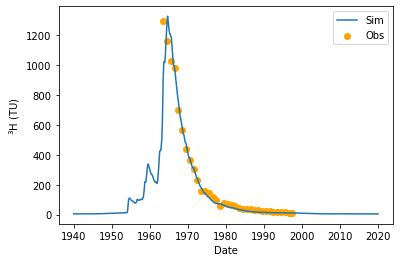

In [16]:
plt.plot(sample_dates, Cout_sim)
plt.scatter(Cout_obs_dates, Cout_obs, c='orange')
plt.legend(['Sim', 'Obs'])
plt.xlabel('Date')
plt.ylabel('$^3$H (TU)')
plt.show()

# EPM

Define the exponential piston-flow model functions.

In [17]:
def epm(tt, Cin, tau, lambd, n, uz_time, tol):
    mult = n/tau * 1/(n/tau + lambd)
    half1 = np.exp(-(n/tau + lambd) * tt[:-1] + n-1)
    half2 = np.exp(-(n/tau + lambd) * tt[1:]   + n-1)
    Cout = Cin[1:] * np.exp(-lambd*uz_time) * mult * (half1 - half2)
    # Do same tolerance check as TracerLPM
    chk = np.diff(np.cumsum(Cout)) / np.cumsum(Cout)[1:]
    idx = np.argmax(chk<tol) + 2
    return sum(Cout[:idx])

def lpm_epm(sample_dates, dates, Cin, lambd, tau, epm_ratio, uz_time, tol=1e-6):
    n = 1 + epm_ratio
    min_age = tau * (1 - 1/n)
    Cout = []
    for sample_date in sample_dates:
        sel = ((sample_date-dates) >= min_age)
        dates_sel = dates[sel]
        tt_sel = sample_date - dates_sel
        Cin_sel = Cin[sel]
        Cout.append(epm(tt_sel, Cin_sel, tau, lambd, n, uz_time, tol))
    return Cout

In [18]:
sample_dates = dates[dates>=1940]
lambd = np.log(2)/12.32
tau = 2.5
epm_ratio = 0.001
uz_time = 0
Cout_sim2 = lpm_epm(sample_dates, dates, Cin, lambd, tau, epm_ratio, uz_time)

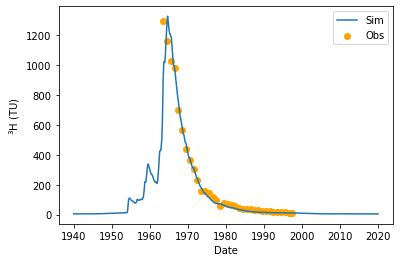

In [19]:
plt.plot(sample_dates, Cout_sim)
plt.scatter(Cout_obs_dates, Cout_obs, c='orange')
plt.legend(['Sim', 'Obs'])
plt.xlabel('Date')
plt.ylabel('$^3$H (TU)')
plt.show()

# Optimise parameters

Here are two methods that can be used to optimise the parameters for the models using scipy and spotpy.

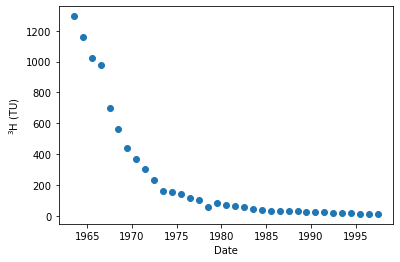

In [20]:
# Only optimise for sample dates
sample_dates = df.dropna()['Date'].values
obs = df.dropna()['Cout'].values
plt.scatter(sample_dates, obs)
plt.ylabel('$^3$H (TU)')
plt.xlabel('Date')
plt.show()

### Scipy

Example optimising EMM with scipy.optimise and the root mean squared error

In [21]:
from scipy.optimize import minimize, minimize_scalar

**Optimising EMM**

Optimisation is performed using the Brent method within the specified bounds for tau.

In [22]:
def optim_emm(tau):
    sim = lpm_emm(sample_dates, dates, Cin, lambd, tau, uz_time)
    rmse = np.sqrt( np.mean( (sim-obs)**2 ) )
    return rmse

In [23]:
opt = minimize_scalar(optim_emm, bounds=(1,100), method='bounded')

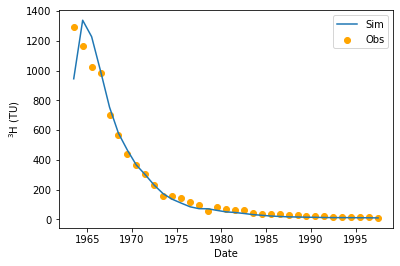

In [24]:
opt_emm = lpm_emm(sample_dates, dates, Cin, lambd, opt['x'], uz_time)
plt.plot(sample_dates, opt_emm)
plt.scatter(Cout_obs_dates, Cout_obs, c='orange')
plt.legend(['Sim', 'Obs'])
plt.xlabel('Date')
plt.ylabel('$^3$H (TU)')
plt.show()

**EPM**

Optimise the two parameters in EPM tau and the EPM ratio using the sequential quadratic programming algorithm

In [25]:
def optim_epm(pars):
    sim = lpm_epm(sample_dates, dates, Cin, lambd, pars[0], pars[1], uz_time)
    rmse = np.sqrt( np.mean( (sim-obs)**2 ) )
    return rmse

In [26]:
x0 = (2.5, 0.5)
opt = minimize(optim_epm,
               x0=x0,
               method='SLSQP',
               bounds=[(1., 3.), (0.001, 1.)])

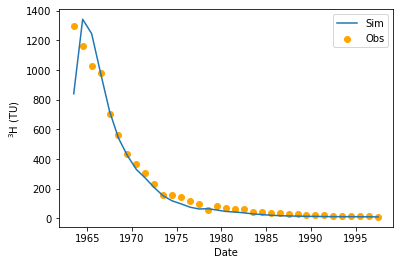

In [27]:
opt_epm = lpm_epm(sample_dates, dates, Cin, lambd, opt['x'][0], opt['x'][1], uz_time)
plt.plot(sample_dates, opt_epm)
plt.scatter(Cout_obs_dates, Cout_obs, c='orange')
plt.legend(['Sim', 'Obs'])
plt.xlabel('Date')
plt.ylabel('$^3$H (TU)')
plt.show()

### Spotpy

A more sophisticated/flexible way to optimise parameters.

https://spotpy.readthedocs.io/en/latest/

In [28]:
import spotpy

Set up a spotpy class to pass in the parameter sets to be evaluated.

This example uses the Nash-Sutcliffe Efficiency, but there are many other objective functions.

In [29]:
class spot_setup(object):
    def __init__(self, params):
        self.params = params
        self.evals = obs
  
    def parameters(self):
        return(spotpy.parameter.generate(self.params))
    
    def simulation(self,x):
        sim = lpm_epm(sample_dates, dates, Cin, lambd, x[0], x[1], uz_time)
        return sim

    def evaluation(self):
        return self.evals

    def objectivefunction(self,simulation,evaluation):
        objectivefunction = spotpy.objectivefunctions.nashsutcliffe(evaluation,simulation)
        return objectivefunction

**Evaluating specific parameter combinations**

Evaluate combinations of discrete parameter ranges

In [30]:
# Ranges/steps to evaluate tau and the epm ratio over
tau_seq = np.arange(0.25, 5, 0.25)
epm_ratio_seq = np.arange(0.01, 1, 0.01)
# Create combinations and flatten
tau_grd, epm_ratio_grd = np.meshgrid(tau_seq, epm_ratio_seq)
tau_pars = tau_grd.reshape(-1)
epm_ratio_pars = epm_ratio_grd.reshape(-1)

In [31]:
params = [spotpy.parameter.List('tau' , tau_pars),
          spotpy.parameter.List('epm_ratio', epm_ratio_pars)]
epm_setup = spot_setup(params)
sampler = spotpy.algorithms.mc(epm_setup, optimization_direction='maximize')
sampler.sample(len(tau_pars))
results = sampler.getdata()

Initializing the  Monte Carlo (MC) sampler  with  1881  repetitions
The objective function will be maximized
Starting the MC algorithm with 1881 repetitions...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
389 of 1881, maximal objective function=0.930892, time remaining: 00:00:08
773 of 1881, maximal objective function=0.930892, time remaining: 00:00:06
1175 of 1881, maximal objective function=0.930892, time remaining: 00:00:04
1600 of 1881, maximal objective function=0.930892, time remaining: 00:00:01

*** Final SPOTPY summary ***
Total Duration: 9.35 seconds
Total Repetitions: 1881
Maximal objective value: 0.930892
Corresponding parameter setting:
tau: 2
epm_ratio: 0.01
******************************



A plot of the best model run has been saved as Best_model_run.png


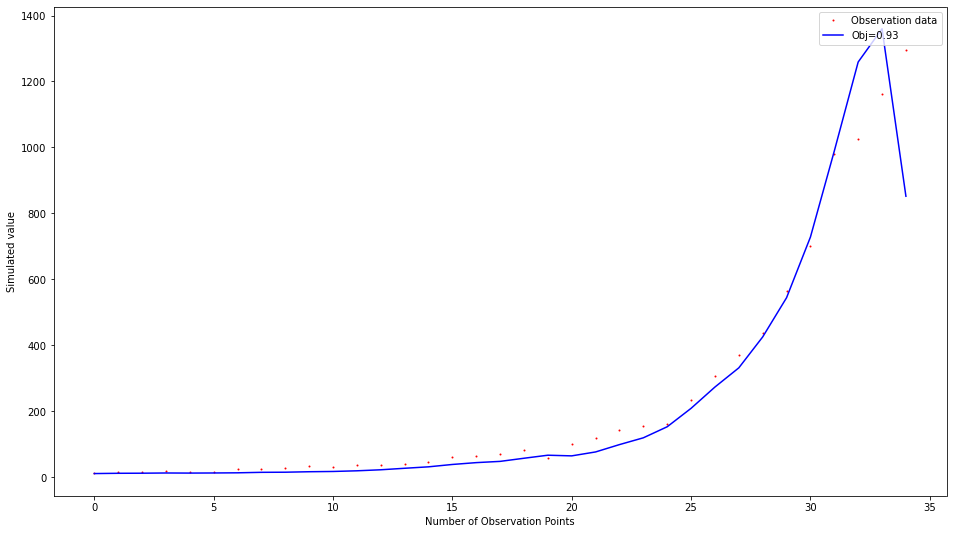

In [32]:
# Best model
spotpy.analyser.plot_bestmodelrun(results, obs)

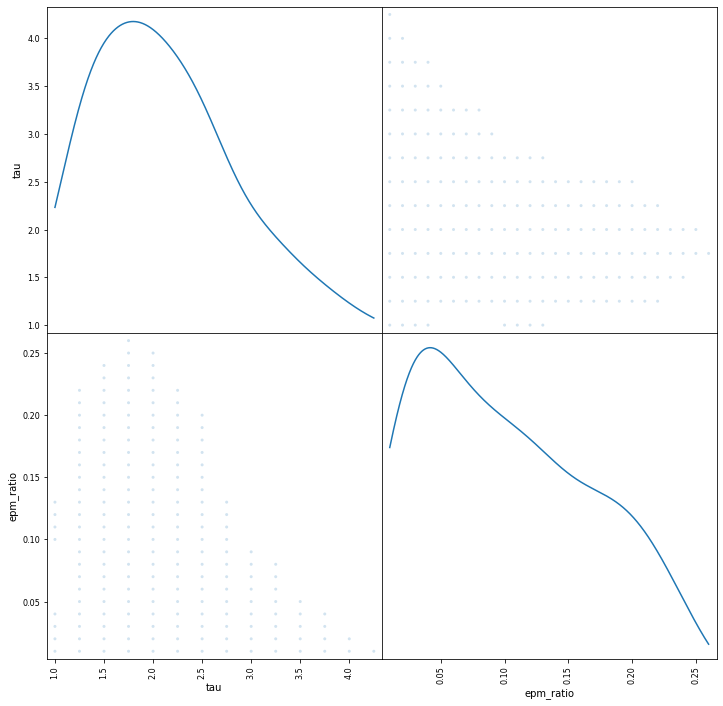

In [33]:
# Best 10% of the model runs
posterior = spotpy.analyser.get_posterior(results, percentage=10)
spotpy.analyser.plot_parameterInteraction(posterior)

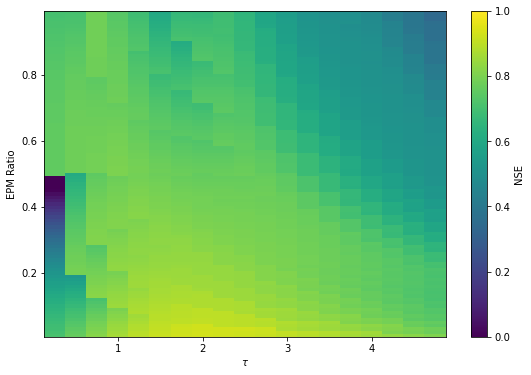

In [34]:
# Heatmap
plt.figure(figsize=(9,6))
results = sampler.getdata()
plt.pcolormesh(tau_grd, epm_ratio_grd, results['like1'].reshape(tau_grd.shape), shading='auto')
plt.colorbar(label='NSE')
plt.clim(0, 1)
plt.xlabel(r'$\tau$')
plt.ylabel('EPM Ratio')
plt.show()

### Algorithm

Example for automatic optimisation using Monte Carlo

In [35]:
# Example to optimise automatically
params = [spotpy.parameter.Uniform('tau', low=1.5, high=3.5, optguess=2.5),
          spotpy.parameter.Uniform('epm_ratio', low=1e-4, high=1e-1, optguess=1e-3)]
epm_setup = spot_setup(params)
sampler = spotpy.algorithms.mc(epm_setup, optimization_direction='maximize')
sampler.sample(3000)
results = sampler.getdata()

Initializing the  Monte Carlo (MC) sampler  with  3000  repetitions
The objective function will be maximized
Starting the MC algorithm with 3000 repetitions...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
385 of 3000, maximal objective function=0.931349, time remaining: 00:00:14
773 of 3000, maximal objective function=0.931349, time remaining: 00:00:12
1162 of 3000, maximal objective function=0.93139, time remaining: 00:00:09
1553 of 3000, maximal objective function=0.931415, time remaining: 00:00:07
1946 of 3000, maximal objective function=0.931415, time remaining: 00:00:05
2337 of 3000, maximal objective function=0.931415, time remaining: 00:00:03
2727 of 3000, maximal objective function=0.931415, time remaining: 00:00:01

*** Final SPOTPY summary ***
Total Duration: 15.43 seconds
Total Repetitions: 3000
Maximal objective value: 0.931415
Corresponding parameter setting:
tau: 1.99069
epm_ratio: 0.000451777
******************************



A plot of the best model run has been saved as Best_model_run.png


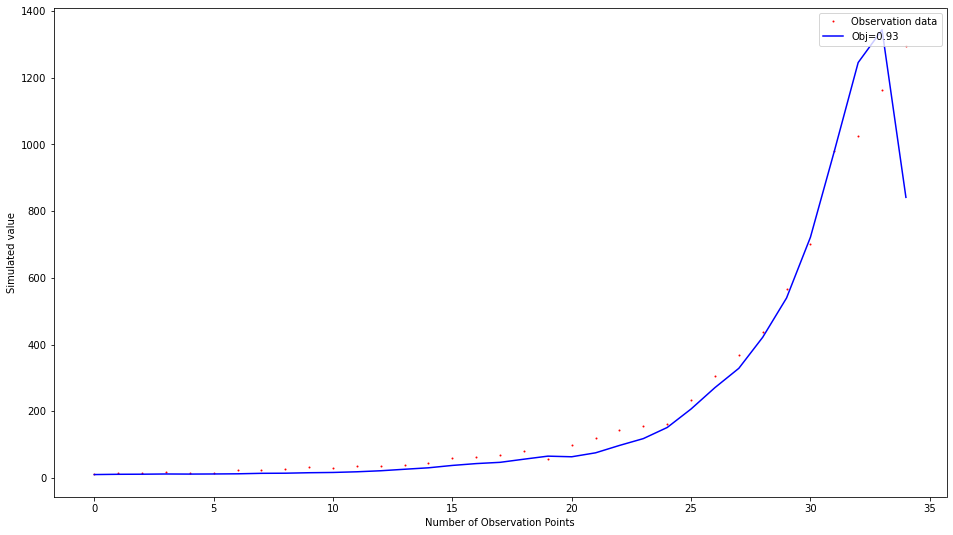

In [36]:
spotpy.analyser.plot_bestmodelrun(results, obs)

A plot of the parameter uncertainty has been saved as Posterior_parameter_uncertainty.png


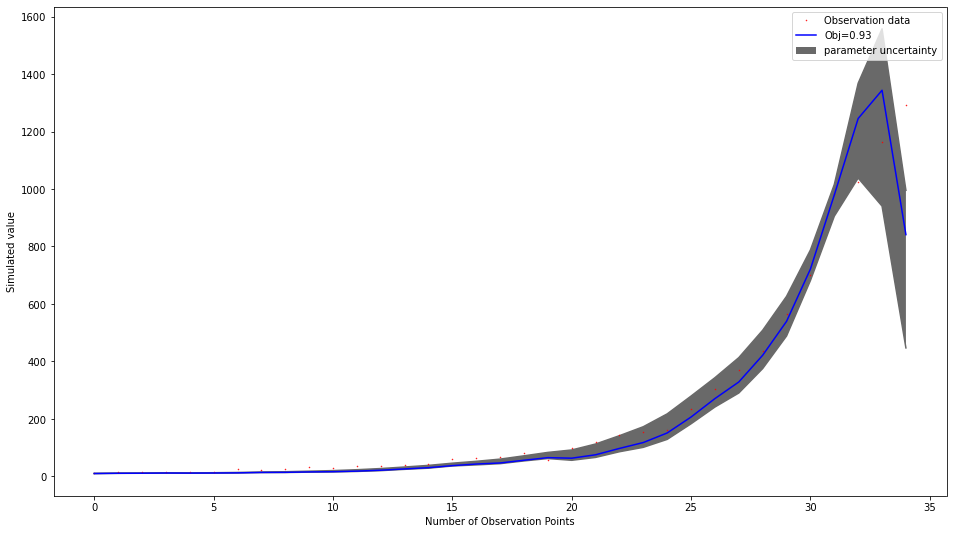

In [37]:
spotpy.analyser.plot_parameter_uncertainty(results, obs)